# 워드클라우드 예제

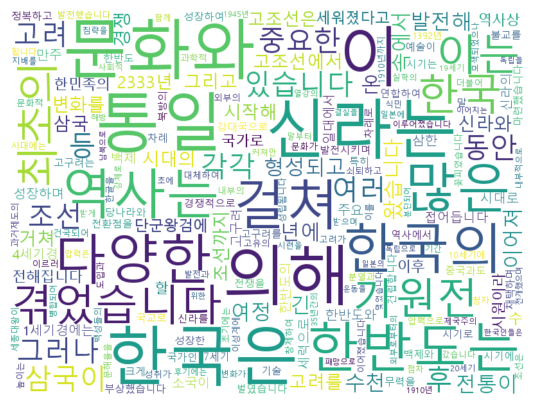

In [3]:
# 사전 설치 : pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

#텍스트 파일 읽기
with open("dataset/history.txt","r",encoding="utf-8") as file:
    text=file.read();
    
#워드클라우드 설정 및 생성
wordcloud=WordCloud(
    font_path="malgun",
    background_color="white",
    width=800,
    height=600,
    max_words=200,
    max_font_size=100,
    min_font_size=10,
    random_state=42
).generate(text);

#워드 클라우드 이미지 시각화
plt.figure(figsize=(10,5));
plt.imshow(wordcloud, interpolation="bilinear");
plt.axis("off");


# Gradio

## 챗봇예제(Gradio 사용)

In [4]:
# 사전 설치 : pip install gradio
from langchain_community.chat_models import ChatOllama
from langchain.schema import HumanMessage, AIMessage
import gradio as gr

#ChatOllama 모델 초기화
model=ChatOllama(model="gemma2", temperature=0.7, verbose=False);   #temperature: 문장의 자유도

#채팅 기록을 포함하여 응답을 생성하는 함수
def chat(message, history):
    #이전 대화 기록을 ChatOllama 형식으로 변환
    chat_history=[];
    for human, ai in history:
        chat_history.append(HumanMessage(content=human));
        chat_history.append(AIMessage(content=ai));
        
    #현재 메시지 추가
    chat_history.append(HumanMessage(content=message));
    
    #모델을 사용하여 응답 생성
    response=model.invoke(chat_history);
    
    return response.content;

d:\241223\aiProject2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\human-10\AppData\Local\Temp\ipykernel_11388\2076494958.py:7: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model=ChatOllama(model="gemma2", temperature=0.7, verbose=False);   #temperature: 문장의 자유도


In [6]:
#Gradio 인터페이스 설정
demo=gr.ChatInterface(
    fn=chat,
    examples=[
        "안녕하세요!",
        "인공지능에 대해 설명해주세요.",
        "파이썬의 장점은 무엇인가요?"
    ],
    title="AI 챗봇",
    description="질문을 입력하면 AI가 답변합니다."
);

#서버 실행
demo.launch(server_port=7861, server_name="0.0.0.0");       #localhost:7861로 접속가능



d:\241223\aiProject2\.venv\lib\site-packages\gradio\components\chatbot.py:248: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://0.0.0.0:7861

To create a public link, set `share=True` in `launch()`.


In [7]:
#자원 회수
demo.close();

Closing server running on port: 7861


# 챗봇 예제(Gradio+csv 사용)

In [19]:
import pandas as pd
from langchain_community.chat_models import ChatOllama
from langchain.schema import HumanMessage, AIMessage
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
import gradio as gr

#CSV 파일 로드
df=pd.read_csv("dataset/indata_kor.csv", encoding="CP949");
print(df.tail());

#텍스트 분할
text_splitter=CharacterTextSplitter(chunk_size=1000, chunk_overlap=200);
texts=text_splitter.split_text("\n".join(df.to_string()));


                                   inputs  \
27         한국폴리텍대학 스마트금융과의 최종 아웃풋은 어떤건가요?   
28       한국폴리텍대학 스마트금융과의 최종 포트폴리오는 어떤건가요?   
29  한국폴리텍대학 스마트금융과 면접시에는 어떤걸 준비하고 가면 될까요?   
30    한국폴리텍대학 스마트금융과 입학 전까지 어떤걸 공부하면 될까요?   
31   한국폴리텍대학 스마트금융과는 대면/비대면 수업 어떻게 진행되나요?   

                                             response  
27  스마트금융과는 찍어내기식의 포트폴리오가 아니라 매년 업체에서 요구하는 기술 및 주제...  
28  유튜브 채널에서 스마트금융과를 검색하시면 한국폴리텍대학 스마트금융과 포트폴리오 발표...  
29                   영문 타자연습 및 스마트금융과에 대한 열정을 보여주면 좋다  
30  기본적인 OA를 잘 다루고 기본코드는 HKCODE의 기본 내용은 보고오면 됨. 파이...  
31                                        대면으로 진행합니다.  


In [20]:
#임베딩 모델 초기화
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v2")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2");

#벡터 데이터베이스 생성
vectorstore=FAISS.from_texts(texts, embeddings);

#ChatOllama 모델 초기화
llm=ChatOllama(model="gemma2", temperature=0.1);

qa_chain=ConversationalRetrievalChain.from_llm(
    llm,
    vectorstore.as_retriever(search_kwargs={"k":1}),
    return_source_documents=True,
    verbose=False
);


C:\Users\human-10\AppData\Local\Temp\ipykernel_11388\1909278097.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2");


In [21]:
#채팅함수 정의
def chat(message, history):
    #이전 대화기록을 ConversationRetrievalChain 형식으로 변환
    chat_history=[(human, ai) for human, ai in history];
    
    #모델을 사용하여 응답 생성
    response=qa_chain({"question":message, "chat_history":chat_history});
    
    #소스 문서 정보 추출
    sources=set([doc.metadata.get("source", "Unknown") for doc in response["source_documents"]]);
    source_info=f"\n\n참고 출처:{','.join(sources)}" if sources else "";
    
    return response["answer"]+source_info;

#Gradio 인터페이스 설정
demo=gr.ChatInterface(
    fn=chat,
    examples=[
        "한국폴리텍대학 스마트금융과 면접시에는 어떤 걸 준비하고 가면 될까요?",
        "스마트금융과에 대해 설명해주세요",
        "한국폴리텍대학 추천할만한 학과 하나를 소개해주세요"
    ],
    title="대학 정보  AI 챗봇",
    description="스마트금융과에 대한 질문을 입력하면 AI가 CSV데이터를 참고하여 한글로 답변합니다"
)

d:\241223\aiProject2\.venv\lib\site-packages\gradio\components\chatbot.py:248: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


In [22]:
#서버실행
demo.launch(server_port=7861, server_name="0.0.0.0");

* Running on local URL:  http://0.0.0.0:7861

To create a public link, set `share=True` in `launch()`.


In [23]:
#자원회수
demo.close();

Closing server running on port: 7861


## 챗봇예제(인터넷 URL 정보 요약하기)

In [7]:
import gradio as gr
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
import ollama

#Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader=WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict()
    )
    
    docs=loader.load();
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200);
    splits=text_splitter.split_documents(docs);
    embeddings=OllamaEmbeddings(model="gemma2");
    
    #vectorstore=Chroma.from_documents(documents=splits, embedding=embeddings)
    vectorstore=FAISS.from_documents(documents=splits, embedding=embeddings);
    
    return vectorstore.as_retriever();

#Function to format documents
def format_docs(docs):
    return"\n\n".join(doc.page_content for doc in docs);

#Function that defines the RAG chain
def rag_chain(url, question):
    retriever=load_and_retrieve_docs(url);
    retrieved_docs=retriever.invoke(question);
    formatted_context=format_docs(retrieved_docs);
    formatted_prompt=f"Question:{question}\m\mContext:{formatted_context}";
    response=ollama.chat(model="gemma2",messages=[{"role":"user", "content":formatted_prompt}]);
    return response["message"]["content"];

In [8]:
#Gradio interface
iface=gr.Interface(
    fn=rag_chain,
    inputs=["text","text"],
    outputs="text",
    title="RAG chain Question Answering",
    description="Enter a URL and a query to get answers from the RAG chain"
)

#디버그 모드로 Gradio 인터페이스 실행
iface.launch(server_port=7861, server_name="0.0.0.0", debug=True);

* Running on local URL:  http://0.0.0.0:7861

To create a public link, set `share=True` in `launch()`.


Using existing dataset file at: .gradio\flagged\dataset1.csv


C:\Users\human-10\AppData\Local\Temp\ipykernel_12944\1976474383.py:19: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings=OllamaEmbeddings(model="gemma2");


Keyboard interruption in main thread... closing server.


In [9]:
#자원회수
iface.close();

Closing server running on port: 7861
